# Modelado tabular — Viabilidad de startups

En este cuaderno entreno modelos con variables tabulares (sin texto). Comparo baselines y modelos candidatos.
La métrica principal es **ROC-AUC** y como secundarias uso F1, precisión, recall y accuracy.

El modelo ganador se guarda en `models/modelo_tabular.joblib`.

## 1. Setup y carga de datos

In [3]:
from pathlib import Path
import sys

def find_root(start: Path = None) -> Path:
    p = start or Path.cwd()
    for cand in [p, *p.parents]:
        if (cand / "src").exists() and (cand / "data").exists():
            return cand
    raise FileNotFoundError("No se encontró la raíz del proyecto")

PROJECT_ROOT = find_root()
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

PROJECT_ROOT

WindowsPath('c:/Users/carlo/OneDrive/Escritorio/Proyecto Machine Learning')

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from scipy.stats import randint as sp_randint, uniform
import joblib

RANDOM_STATE = 42

DATA_PATH = PROJECT_ROOT / "data/processed/startups_sintetico_15000_processed.csv"
df = pd.read_csv(DATA_PATH, encoding="utf-8")
print("Ruta:", DATA_PATH)
print("Shape:", df.shape)
df.head()

Ruta: c:\Users\carlo\OneDrive\Escritorio\Proyecto Machine Learning\data\processed\startups_sintetico_15000_processed.csv
Shape: (15000, 51)


,monto_financiado,num_rondas,tamano_equipo,exp_fundadores,presencia_redes,inversores_destacados,descripcion,tiempo_fundacion,viabilidad,flag_na_monto_financiado,...,ubicacion_trujillo,estado_operativo_activo,estado_operativo_cerrado,estado_operativo_en pausa,estado_operativo_nan,estado_operativo_prototipo,antiguedad_bucket_0-1,antiguedad_bucket_2-3,antiguedad_bucket_4-7,antiguedad_bucket_8+
0,1555000.0,2.0,49.0,8.7,8.5,0.0,equipo con 8+ años de experiencia. operando en...,2016.0,1,0,...,False,True,False,False,False,False,False,False,False,True
1,4217000.0,1.0,9.0,1.2,-5.0,0.0,operando en el mercado,2007.0,1,0,...,False,True,False,False,False,False,False,False,False,True
2,1224000.0,5.0,17.0,2.5,77.3,0.0,buena presencia en redes. operando en el merca...,2019.0,1,0,...,False,True,False,False,False,False,False,False,True,False
3,4922000.0,4.0,35.0,6.1,23.5,0.0,equipo con 6+ años de experiencia. operando en...,2017.0,0,0,...,False,True,False,False,False,False,False,False,False,True
4,2968000.0,3.0,38.0,2.9,5.4,1.0,apoyo de inversores reconocidos. operando en e...,2015.0,1,0,...,False,True,False,False,False,False,False,False,False,True


## 2. Construcción de X e y

In [5]:
df_tab = df.drop(columns=["descripcion"]) if "descripcion" in df.columns else df.copy()

obj_cols = df_tab.select_dtypes(include=["object","category"]).columns.tolist()
if obj_cols:
    df_tab = pd.get_dummies(df_tab, columns=obj_cols, drop_first=False)
    print("One-Hot on-the-fly:", obj_cols)

y = df_tab["viabilidad"].astype(int)
X = df_tab.drop(columns=["viabilidad"])

X.shape, y.shape

One-Hot on-the-fly: ['sector_x_estado']


((15000, 98), (15000,))

## 3. Split 70/15/15

In [6]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=RANDOM_STATE
)
X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=RANDOM_STATE
)

print("Train:", X_train.shape, "Valid:", X_valid.shape, "Test:", X_test.shape)

Train: (10500, 98) Valid: (2250, 98) Test: (2250, 98)


## 4. Función de evaluación

In [7]:
def eval_model(clf, Xv, yv, name):
    proba = clf.predict_proba(Xv)[:,1] if hasattr(clf,"predict_proba") else clf.decision_function(Xv)
    auc = roc_auc_score(yv, proba)
    pred = (proba >= 0.5).astype(int)
    return {
        "model": name,
        "auc": float(auc),
        "f1": float(f1_score(yv, pred)),
        "acc": float(accuracy_score(yv, pred)),
        "prec": float(precision_score(yv, pred, zero_division=0)),
        "rec": float(recall_score(yv, pred, zero_division=0))
    }

## 5. Baselines

In [8]:
results = []

dummy = DummyClassifier(strategy="stratified", random_state=RANDOM_STATE)
dummy.fit(X_train, y_train)
results.append(eval_model(dummy, X_valid, y_valid, "Dummy"))

logit = Pipeline([
    ("scaler", StandardScaler(with_mean=False)),
    ("clf", LogisticRegression(max_iter=1000, random_state=RANDOM_STATE))
])
logit.fit(X_train, y_train)
results.append(eval_model(logit, X_valid, y_valid, "LogReg"))

pd.DataFrame(results)

,model,auc,f1,acc,prec,rec
0,Dummy,0.484830,0.557632,0.495111,0.562893,0.552469
1,LogReg,0.703723,0.720228,0.650222,0.667765,0.781636


## 6. Modelos candidatos + tuning

In [9]:
tree = DecisionTreeClassifier(random_state=RANDOM_STATE)
tree.fit(X_train, y_train)
results.append(eval_model(tree, X_valid, y_valid, "DecisionTree"))

rf = RandomForestClassifier(random_state=RANDOM_STATE)
rf_grid = {"n_estimators":[200,400], "max_depth":[None,10,20], "min_samples_split":[2,5]}
rf_cv = GridSearchCV(rf, rf_grid, cv=5, scoring="roc_auc", n_jobs=-1)
rf_cv.fit(X_train, y_train)
best_rf = rf_cv.best_estimator_
results.append(eval_model(best_rf, X_valid, y_valid, f"RandomForest{rf_cv.best_params_}"))

hgb = HistGradientBoostingClassifier(random_state=RANDOM_STATE)
hgb_dist = {
    "max_depth": sp_randint(2, 16),
    "learning_rate": uniform(0.02, 0.28),
    "max_bins": sp_randint(32, 255)
}
hgb_cv = RandomizedSearchCV(hgb, hgb_dist, cv=5, n_iter=20, scoring="roc_auc",
                            random_state=RANDOM_STATE, n_jobs=-1)
hgb_cv.fit(X_train, y_train)
best_hgb = hgb_cv.best_estimator_
results.append(eval_model(best_hgb, X_valid, y_valid, "HistGB(best)"))

df_val = pd.DataFrame(results).sort_values("auc", ascending=False)
df_val

,model,auc,f1,acc,prec,rec
4,HistGB(best),0.712130,0.731417,0.659556,0.670308,0.804784
1,LogReg,0.703723,0.720228,0.650222,0.667765,0.781636
3,"RandomForest{'max_depth': 10, 'min_samples_spl...",0.701647,0.743216,0.655111,0.650637,0.866512
2,DecisionTree,0.568877,0.625882,0.576000,0.636364,0.615741
0,Dummy,0.484830,0.557632,0.495111,0.562893,0.552469


## 7. Selección final y evaluación en test

In [10]:
top_name = df_val.iloc[0]["model"]
if "HistGB" in top_name:
    final_model = best_hgb
elif "RandomForest" in top_name:
    final_model = best_rf
elif "LogReg" in top_name:
    final_model = logit
else:
    final_model = tree

X_trv = pd.concat([X_train, X_valid], axis=0)
y_trv = pd.concat([y_train, y_valid], axis=0)
final_model.fit(X_trv, y_trv)
final_model._feature_names = list(X_trv.columns)
print('N° de features usadas en el modelo tabular:', len(final_model._feature_names))

proba_test = final_model.predict_proba(X_test)[:,1] if hasattr(final_model,"predict_proba") else final_model.decision_function(X_test)
pred05 = (proba_test >= 0.5).astype(int)

print("Modelo final:", top_name)
print("AUC test:", round(roc_auc_score(y_test, proba_test),3))
print("F1 test @0.5:", round(f1_score(y_test, pred05),3))
print("Accuracy test:", round(accuracy_score(y_test, pred05),3))
print("Matriz de confusión @0.5:\n", confusion_matrix(y_test, pred05))

N° de features usadas en el modelo tabular: 98
Modelo final: HistGB(best)
AUC test: 0.712
F1 test @0.5: 0.732
Accuracy test: 0.661
Matriz de confusión @0.5:
 [[ 446  508]
 [ 255 1041]]


## 8. Curvas ROC y PR

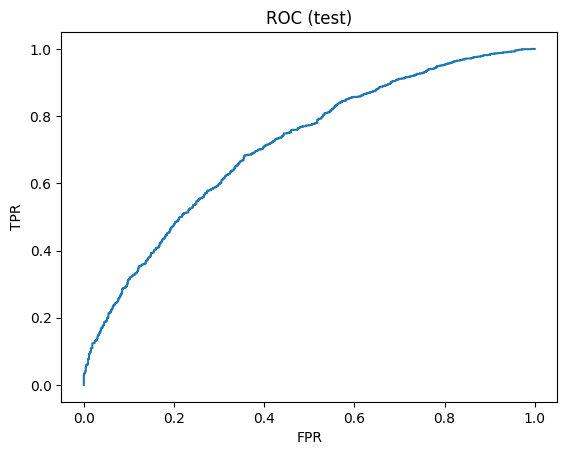

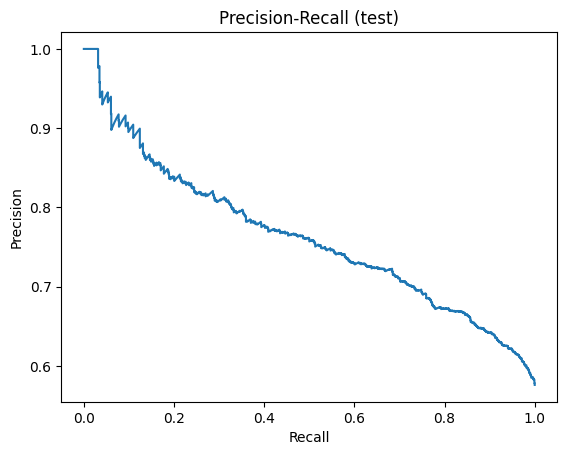

In [11]:
fpr, tpr, _ = roc_curve(y_test, proba_test)
prec, rec, _ = precision_recall_curve(y_test, proba_test)

plt.figure(); plt.plot(fpr, tpr)
plt.title("ROC (test)"); plt.xlabel("FPR"); plt.ylabel("TPR")
plt.show()

plt.figure(); plt.plot(rec, prec)
plt.title("Precision-Recall (test)"); plt.xlabel("Recall"); plt.ylabel("Precision")
plt.show()

## 9. Guardar modelo final

In [12]:
MODEL_OUT = PROJECT_ROOT / "models/modelo_tabular.joblib"
MODEL_OUT.parent.mkdir(parents=True, exist_ok=True)
joblib.dump(final_model, MODEL_OUT)

print("✅ Modelo tabular guardado en:", MODEL_OUT)

✅ Modelo tabular guardado en: c:\Users\carlo\OneDrive\Escritorio\Proyecto Machine Learning\models\modelo_tabular.joblib
